# Imports

In [176]:
import sys


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr
from scipy.stats import spearmanr


import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import plotly.tools as tls

import plotly.graph_objects as go

In [177]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
%autoreload 2

# Goal

# Dataset

We started with the CMU movie.metadata dataset. It contains 81740 movies with the following useful  information: Name, Release_Date, Revenue, Runtime and Genres. In order to be able to analyze the Foreign Revenue and Domestic Revenue, we were able to supplement our dataset using a concatenation of information from Kaggle, Box Office Mojo, IMDb, Rotten Tomatoes, and TheMovieDB available at [https://github.com/ntdoris/movie-revenue-analysis](here).   We then further augmented our dataset by scrapping information from The Numbers (domestic and foreign gross and genres), Rotten Tomatoes (reviews, ratings, runtime and plot summary), Wikipedia (country), and Box Office Mojo (domestic and foreign gross).   
Emotional classification of the plot summaries into the seven following categories : suprise, fear, disgust, joy, anger, sadness and neutral was done using Hartman's DistilRoberta model available at [https://huggingface.co/j-hartmann/emotion-english-distilroberta-base](here). All of our USD values were adjusted for inflation to 2024. 

In [179]:
df = pd.read_csv('data/movie_final_dataset.csv')
df.head()

,Name,Genres,Budget(USD)_Inflated,Domestic(USD)_Inflated,Domestic_Percentage,Foreign(USD)_Inflated,Foreign_Percentage,Worldwide(USD)_Inflated,Runtime(mins),Rating,...,period piece,animation,teen,film adaptation,musical,history,coming of age,sports,war,Worldwide_profit
0,10 cloverfield lane,"drama, thriller, horror, sci-fi",6.076746e+06,8.760602e+07,0.654010,4.634613e+07,0.345990,1.339521e+08,103,pg-13,...,0,0,0,0,0,0,0,0,0,22.043400
1,"10,000 bc","drama, thriller, action, adventure, romance fi...",1.441563e+08,1.301309e+08,0.351333,2.402606e+08,0.648667,3.703914e+08,109,pg-13,...,0,0,0,0,0,0,0,0,0,2.569373
2,12 rounds,"thriller, action, crime",2.726275e+07,1.667757e+07,0.708013,6.877890e+06,0.291987,2.355546e+07,108,pg-13,...,0,0,0,0,0,0,0,0,0,0.864016
3,12 strong,"drama, action, history, war",3.979050e+07,5.209113e+07,0.644274,2.876133e+07,0.355726,8.085246e+07,130,r,...,0,0,0,0,0,1,0,0,1,2.031954
4,12 years a slave,"drama, biography, history",2.539260e+07,7.195247e+07,0.301875,1.663993e+08,0.698125,2.383517e+08,134,r,...,0,0,0,0,0,1,0,0,0,9.386660


The Analysis will be done taking into consideration the movies from the year 2000 to 2019 as the number of movies in the period before the 2000s and after 2019 were not sufficient enough to obtain a reasonable analysis.

![alt text](images/years_img_cleaning.png)

In [180]:
df.columns

Index(['Name', 'Genres', 'Budget(USD)_Inflated', 'Domestic(USD)_Inflated',
       'Domestic_Percentage', 'Foreign(USD)_Inflated', 'Foreign_Percentage',
       'Worldwide(USD)_Inflated', 'Runtime(mins)', 'Rating', 'Audience_Score',
       'Critics_Score', 'plot_summary', 'Month', 'Day', 'Year',
       'Foreign_higher', 'emotion', 'emotion_score', 'drama', 'comedy',
       'thriller', 'action', 'adventure', 'romance film', 'horror', 'fantasy',
       'mystery', 'crime', 'indie', 'biography', 'family', 'sci-fi',
       'period piece', 'animation', 'teen', 'film adaptation', 'musical',
       'history', 'coming of age', 'sports', 'war', 'Worldwide_profit'],
      dtype='object')

### Here is a description of our columns:


- **Name**: The movie name.
- **Runtime(mins)**: The total duration of the movie in minutes.
- **Rating**: The age rating for the movie (eg. r, ..)
- **Audience_Score**: The score given by the audience (from 0-1)
- **Critics_Score**: The score given by movie critics (from 0-1)
- **plot_summary**: A brief summary or description of the movie's plot.
- **Month**: The month the movie was released.
- **Day**: The day the movie was released.
- **Year**: The year the movie was released.

##### Columns representing economic values:  
The following columns have been adjusted for inflation, with all monetary amounts reported in 2023 currency values. Since the inflation rate for 2024 has not yet been released, it was not possible to standardize all figures to 2024.

- **Budget(USD)_Inflated**: The budget of the movie in USD
- **Domestic(USD)_Inflated**: The domestic revenue of the movie in USD
- **Domestic_Percentage**: The percentage of the movie's total revenue that comes from domestic markets.
- **Foreign(USD)_Inflated**: The foreign revenue of the movie in USD
- **Foreign_Percentage**: The percentage of the movie's total revenue that comes from foreign markets.
- **Worldwide(USD)_Inflated**: The worldwide revenue of the movie in USD
- **Foreign_higher**: A binary indicator that shows whether the movie earned more revenue from foreign markets than domestic markets (1 = foreign > domestic, 0 = otherwise).
- **Worldwide_profit**: The total profit ratio of the movie worldwide (calculated as Worldwide Revenue/ Budget).




In [181]:
## TABLE FOR INFLATION:
data = {
    'Year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 
             2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 
             2020, 2021, 2022, 2023],
    'Inflation_Rate': [3.40, 1.60, 2.40, 1.90, 3.30, 3.40, 2.50, 4.10, 0.10, 2.70,
                       1.50, 3.00, 1.70, 1.50, 0.80, 0.70, 2.10, 2.10, 1.90, 2.30,
                       1.40, 7.00, 6.50, 3.40],

}
inflation_df = pd.DataFrame(data)
inflation_df['Cumulative_Inflation'] = (1 + inflation_df['Inflation_Rate'] / 100).cumprod() - 1
inflation_df['Cumulative_Inflation'] = inflation_df['Cumulative_Inflation'] - inflation_df['Cumulative_Inflation'].iloc[0]
inflation_df.head(5)

,Year,Inflation_Rate,Cumulative_Inflation
0,2000,3.4,0.000000
1,2001,1.6,0.016544
2,2002,2.4,0.041757
3,2003,1.9,0.062196
4,2004,3.3,0.098371


Genres:   

To categorize movie genres effectively, the first top 20 most common genres were clustered together. However, this approach led to the exclusion of a significant number of movies due to the diversity of genres. The issue was addressed by clustering related genres under broader, primary genre categories (referred to as "keys").

The process of clustering involved two main steps:

- Exact Keyword Matching:   
Specific sub-genres were grouped under a main genre if the main genre’s keyword was present in the sub-genre’s name. For example, "crime thriller" was included in the subgenres of the "thriller" key and the " crime" key.  
- Semantic Mapping:   
For sub-genres that did not clearly fit under any primary key using exact matching, a semantic text transformer was implemented. This technique analyzed the meaning of genre names and grouped them with the most semantically similar primary key.


In [182]:
"""
{
  "drama": [
    "drama", "comedy-drama", "romantic drama", "family drama", "costume drama", "political drama", 
    "docudrama", "musical drama", "crime drama", "courtroom drama", "melodrama", "marriage drama", 
    "childhood drama", "historical drama", "inspirational drama", "addiction drama", "erotic drama", 
    "legal drama", "fantasy drama"
  ],
  "comedy": [
    "comedy", "romantic comedy", "comedy-drama", "black comedy", "fantasy comedy", "comedy of manners", 
    "crime comedy", "sex comedy", "domestic comedy", "action comedy", "comedy film", "comedy of errors", 
    "adventure comedy", "screwball comedy", "horror comedy", "workplace comedy", "musical comedy", 
    "heavenly comedy", "tragicomedy", "comedy western", "courtroom comedy", "comedy thriller", "comedy horror"
  ],
  "thriller": [
    "thriller", "crime thriller", "psychological thriller", "action thrillers", "thriller/suspense", 
    "political thriller", "erotic thriller", "sci-fi thriller", "comedy thriller"
  ],
  
  "action": [
    "action", "action/adventure", "action thrillers", "action comedy"
  ],  
  "adventure": [
    "adventure", "action/adventure", "fantasy adventure", "family-oriented adventure", 
    "adventure comedy", "costume adventure", "sci-fi adventure"
  ],  
  "romance film": [
    "romance film", "romantic comedy", "romance", "romantic fantasy", "romantic drama"
  ],  
  "horror": [
    "horror", "horror comedy", "natural horror films", "sci-fi horror", "costume horror", 
    "road-horror", "psychological horror", "comedy horror"
  ],  
  "fantasy": [
    "fantasy", "fantasy comedy", "fantasy adventure", "\"childrens fantasy\"", "romantic fantasy", 
    "mythological fantasy", "fantasy drama"
  ],  
  "mystery": ["mystery"],
  "crime": [
    "crime fiction", "crime", "crime thriller", "crime comedy", "crime drama", "law & crime"
  ],  
  "indie": ["indie"],
  "biography": [
    "biography", "biographical film"
  ],  
  "family": [
    "family film", "family", "\"childrens/family\"", "family drama", "family-oriented adventure"
  ],  
  "sci-fi": [
    "sci-fi", "sci-fi horror", "sci-fi adventure", "sci-fi thriller", "science fiction"
  ],  
  "period piece": ["period piece"],
  "animation": [
    "animation", "computer animation", "animated cartoon"
  ],  
  "teen": ["teen"],
  "film adaptation": ["film adaptation"],
  "musical": [
    "musical", "musical drama", "musical comedy", "jukebox musical", "animated musical", "music"
  ],  
  "history": [
    "history", "film & television history"
  ],  
  "coming of age": ["coming of age"],
  "sports": [
    "sports", "extreme sports", "sport", "baseball"
  ],  
  "war": [
    "war film", "war", "anti-war film", "anti-war"
  ]
}
"""

'\n{\n  "drama": [\n    "drama", "comedy-drama", "romantic drama", "family drama", "costume drama", "political drama", \n    "docudrama", "musical drama", "crime drama", "courtroom drama", "melodrama", "marriage drama", \n    "childhood drama", "historical drama", "inspirational drama", "addiction drama", "erotic drama", \n    "legal drama", "fantasy drama"\n  ],\n  "comedy": [\n    "comedy", "romantic comedy", "comedy-drama", "black comedy", "fantasy comedy", "comedy of manners", \n    "crime comedy", "sex comedy", "domestic comedy", "action comedy", "comedy film", "comedy of errors", \n    "adventure comedy", "screwball comedy", "horror comedy", "workplace comedy", "musical comedy", \n    "heavenly comedy", "tragicomedy", "comedy western", "courtroom comedy", "comedy thriller", "comedy horror"\n  ],\n  "thriller": [\n    "thriller", "crime thriller", "psychological thriller", "action thrillers", "thriller/suspense", \n    "political thriller", "erotic thriller", "sci-fi thriller", "c

## Genres

All the plots below evaluate the relationship between genre and revenue.

In [183]:
from src.utils.genre_plots import *
from src.utils.utils import *

The boxplot generated by the code below looks at how much revenue each genre generates from both domestic and foreign audiences. It can be seen that movies from the same type of genres are quite popular in both sets of audiences, particularly animation, fantasy, and science fiction.

In [184]:
genre_col= 'Genres'
domestic_col='Domestic(USD)_Inflated'
foreign_col='Foreign(USD)_Inflated'

df_genre = df[[genre_col, domestic_col, foreign_col]].copy()
df_genre[genre_col] = df_genre[genre_col].str.split(', ')
df_genre = df_genre.explode(genre_col)

fig = create_genre_revenue_plots(
    df_genre=df_genre,
    genre_col='Genres',
    domestic_col='Domestic(USD)_Inflated',
    foreign_col='Foreign(USD)_Inflated'
)
fig.show()
fig.write_image("images/genres.png")


![alt text](images/genres.png)

The plot below demonstrates how popular the respective genres are with each of the respective audiences. The split between the two bars seen below is between movies where a majority of the revenue came from domestic audiences (domestic revenue is greater than 50% of the total worldwide revenue) and those in which the majority of the revenue came from abroad (foreign revenue is greater than 50% of the total worldwide revenue). From the graph, we can see for example that certain genres are more popular with one audience than the other. For example, comedy does much better domestically probably due to cultural and linguistic reasons, while adventure is a genre that captivates a greater share of the foreign audience compared to the domestic audience most likely due to it being much lower on dialogue.

In [185]:
# df_genre = df.copy()
df_genre = df[[genre_col, domestic_col, foreign_col, 'Foreign_higher']].copy()
df_genre[genre_col] = df_genre[genre_col].str.split(', ')
df_genre = df_genre.explode(genre_col)

df_genre_domestic = df_genre[df_genre['Foreign_higher'] == 0]
df_genre_foreign = df_genre[df_genre['Foreign_higher'] == 1]

fig1 = create_stacked_genre_bar_chart(df_genre_domestic, df_genre_foreign)
save = False
fig1.show()
fig1.write_image("images/stacked.png")

![alt text](images/stacked.png)

The two barcharts below look at each genre and the split between domestic and foreign revenue. The first of the two looks at the nominal cumulative value of the domestic/foreign revenue obtained for all movies in the genre. It can be seen that are big gaps for example in action and adventure, again probably for the reasons talked about above. In the second one, we determine the mean percentage for a given movie of a certain genre on how much revenue will be generated by the local market compared to the foreign market. Once again, foreign audiences seem to prefer movies in the genres mentioned earlier. However, we can that sports and teen movies are much more popular domestically, probably because the themes in them are heavily American (e.g. a sports movie about baseball or a teen movie about the American high school experience).

In [186]:
df_genre['Genres'].unique() 
genre_gross = {genre: {'Domestic(USD)_Inflated': 0, 'Foreign(USD)_Inflated': 0} for genre in df_genre['Genres'].unique()}

In [187]:
df_genre['Genres'].unique() 
genre_gross = {genre: {'Domestic(USD)_Inflated': 0, 'Foreign(USD)_Inflated': 0} for genre in df_genre['Genres'].unique()}
fig_gross = create_genre_gross_plot(df, df_genre)
fig_gross.show()
fig_gross.write_image("images/bar_genres.png")

![alt text](images/bar_genres.png)

In [188]:
fig_percentage = create_genre_percentage_plot(df, df_genre)
fig_percentage.show()
fig_percentage.write_image("images/bar_percentages.png")

![alt text](images/bar_percentages.png)

## Audience and Critics Score

In the two histograms below, we look at the spread over the movies based on well they were received. The first plot shows the spread of movies over the audience score from Rotten Tomatoes, and the second one replaces audience score with critics score. Both show similar distributions but just with the critics score being harsher at times. There does not seem to be any meaningful information about greater success with either audience based on scores. 

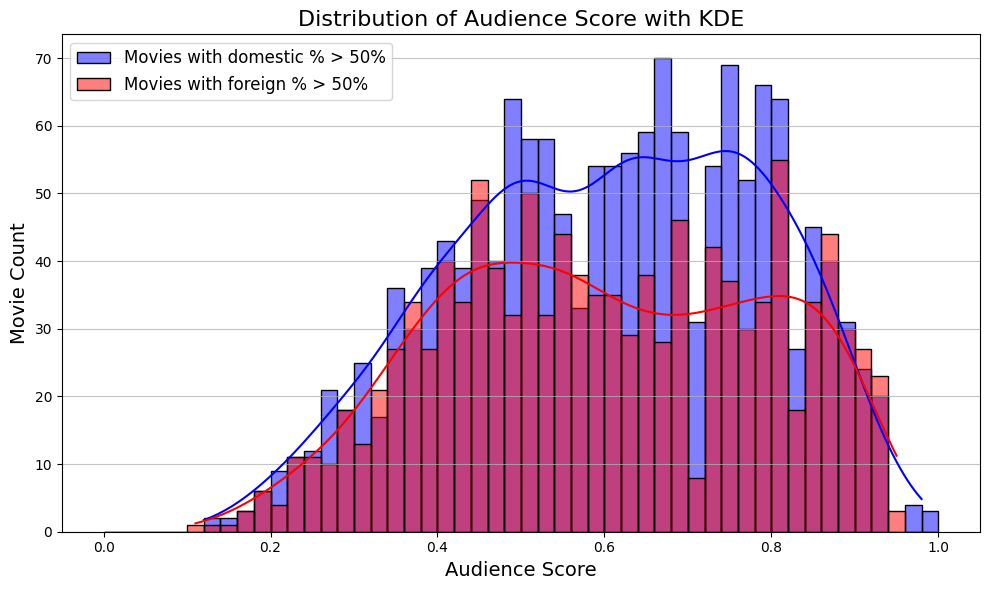

In [189]:
data_domestic_higher = df[df['Foreign_higher'] == 0]['Audience_Score']
data_foreign_higher = df[df['Foreign_higher'] == 1]['Audience_Score']


plot_audience_score_distribution(data_domestic_higher, data_foreign_higher, output_path='audience_score_distribution.png', save=False)

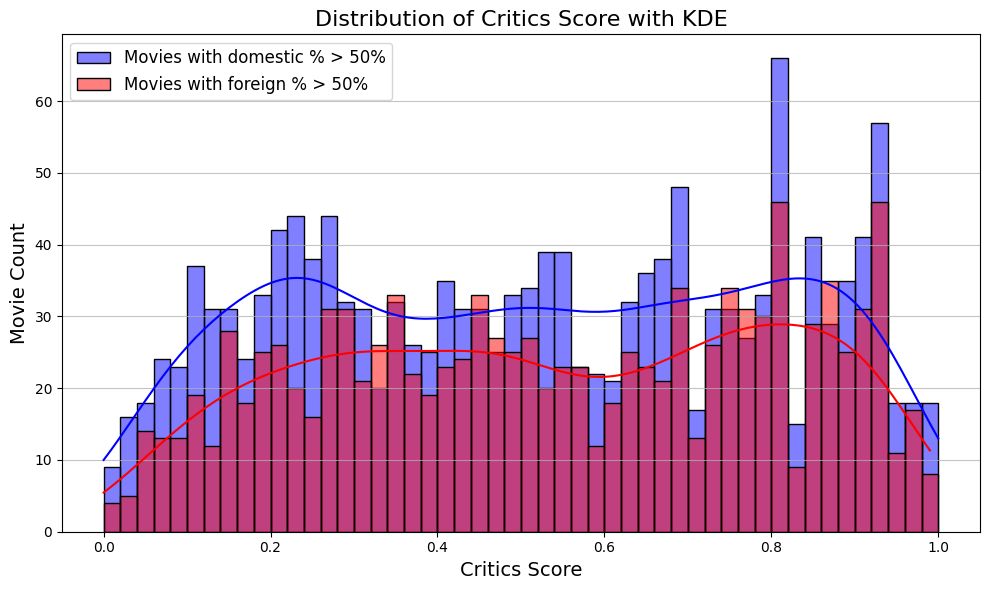

In [190]:
data_domestic_higher = df[df['Foreign_higher'] == 0]['Critics_Score']
data_foreign_higher = df[df['Foreign_higher'] == 1]['Critics_Score']
plot_critics_score_distribution(data_domestic_higher, data_foreign_higher, output_path='critics_score_distribution.png', save=False)

## Factor 

In [191]:
fig_year_plot = generate_year_plot(df)
fig_year_plot.show()
fig_year_plot.write_image("images/fig_year_plot.png")

![alt text](images/fig_year_plot.png)

In [192]:
if save: 
    fig_year_plot.write_html("../_includes/year_plot.html")

Scatter plots

We first did the analysis on the scatter plots to see if it was possible see a dependance between the different features and the foreign percentage. 

In [193]:
fig = px.scatter(
    df,
    x='Budget(USD)_Inflated', 
    y='Foreign_Percentage', 
    title='Foreign Percentage vs Budget(USD)_Inflated',
    labels={'value': 'Percentage', 'variable': 'Type'}, 
    trendline="ols"
)

fig.update_traces(marker=dict(opacity=0.5))
fig.data[1].update(line=dict(color='black'))
fig.show()
fig.write_image("images/foreignvsbudget.png")

![alt text](images/foreignvsbudget.png)

In [194]:
# Calculate Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(df['Budget(USD)_Inflated'], df['Foreign_Percentage'])
print(f"Pearson Correlation Coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.10f}")

correlation, p_value = spearmanr(df['Budget(USD)_Inflated'], df['Foreign_Percentage'])
print(f"Spearman Correlation Coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

Pearson Correlation Coefficient: 0.33
P-value: 0.0000000000
Spearman Correlation Coefficient: 0.35
P-value: 0.0000


## Boxplots

The next step was to explore the distribution of the features we wanted to analyze, notably the budget, runtime, and movie counts. We did this in form of boxplots to be able to visualize the distribution of each while including outliers. We also separated between movies that have more than 50% of revenue from domestic, and those that have more than 50% of revenue internationally. This creates a binary comparison between the two for each boxplot. This allows us to compare whether the movies with more international revenue are more affected in some way by the feature. This will be confirmed later in the actual analysis portion.

### Budget

In [195]:
df_budget = df.copy(deep=True)

df_budget['Foreign_higher'] = df.copy(deep=True)['Foreign_higher'].replace({
    0: "Domestic % > 50%",
    1: "Foreign % > 50%"
})

fig_box_budget = create_box_plot(df, 'Budget(USD)_Inflated', 'Budget (USD)', 'the Log Budget', log= True)
fig_box_budget.show()
fig_box_budget.write_image("images/fig_box_budget.png")

![alt text](images/fig_box_budget.png)

In [196]:
if save: 
    fig_box_budget.write_html("../_includes/log_budget.html")

### Runtime

In [197]:
df_runtime = df.copy(deep=True)

df_runtime['Foreign_higher'] = df.copy(deep=True)['Foreign_higher'].replace({
    0: "Domestic % > 50%",
    1: "Foreign % > 50%"
})

fig_box_runtime = create_box_plot(df, 'Runtime(mins)', 'Runtime(mins)', 'Runtime', log= False)
fig_box_runtime.show()
fig_box_runtime.write_image("images/fig_box_runtime.png")


![alt text](images/fig_box_runtime.png)

In [198]:
if save: 
    fig_box_runtime.write_html("../_includes/runtime_plot.html")

### Movie Counts

In [199]:
df_profitabilty = df.copy(deep=True)

df_profitabilty = df_profitabilty.rename(columns={'Worldwide_profit': 'Worldwide profit', 'Foreign_Percentage': 'Foreign Percentage'})
df_profitabilty = df_profitabilty[df_profitabilty['Worldwide profit'] < 10]


df_profitabilty['Foreign_higher'] = df.copy(deep=True)['Foreign_higher'].replace({
    0: "Domestic % > 50%",
    1: "Foreign % > 50%"
})

# Box plot grouped by Rating and Foreign_higher
fig_box = px.box(df_profitabilty,
    x='Foreign_higher', 
    y='Worldwide profit',  
    color='Foreign_higher', 
    title="Box Plot for Two Classes",
    labels={'value': 'Percentage', 'variable': 'Type'},
    color_discrete_map={"Domestic % > 50%": "blue", "Foreign % > 50%": "red"},  # Customize colors
)

fig_box.for_each_trace(
    lambda t: t.update(name="")
)

fig_box.update_layout(
    title={
        "text": "Distribution of Profitability by Class",
        "x": 0.5,  # Center the title
        "xanchor": "center",  # Anchor the title to the center
    },
    xaxis_title="Class",
    yaxis_title="Profitability",
    legend_title="Key",
)

fig_bar = create_bar_plot(df, 'Movie Counts by Class', 'Worldwide profit')
fig_combined = fig_combined_plots(fig_box, fig_bar, "Movie Counts", log = False)
fig_combined.show()
fig_combined.write_image("images/moviecounts.png")

![alt text](images/moviecounts.png)

In [200]:
if save: 
    fig.write_html("../_includes/profitability_count.html")

## Ratings

We want to look at the domestic vs. foreign preference for ratings of a movie. We dropped the ng-17 rating since there are only 5 of them. We also choose to take the logarithm of the profitability because there were many outliers skewing our data.


In [201]:
ratings_df = pd.read_csv('data/movie_final_dataset.csv')



In [202]:
# droping ng-17 since there's only 5
rating_df = df[df["Rating"] != "nc-17"]

In [203]:
rating_df["log_profit"] = np.log(rating_df["Worldwide_profit"])

C:\Users\lolon\AppData\Local\Temp\ipykernel_18964\263642932.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We choose to compare box plots of movies of different ratings based on the majority foreign or domestic percentage of revenue. We also include a bar chart to show the amount of movies for each category, to come to the conclusion that the G rating should be dropped as well as there are significantly less than the others, and the results and therefore less reliable. The box plots show the distribution, and an analysis can be made on the median values. 

In [204]:
## Box plot check the distribution for each rating, accompanied by count
fig_combined = plot_rating_profit_count(rating_df)
fig_combined.show()
fig_combined.write_image("images/ratings.png")

![alt text](images/ratings.png)

We wanted to see if the results were significant, so we performed an analysis to find the normality of the distribution called the Shapiro-Wilk Test. If the results were normal, we were able to use the ANOVA test to see if the differences between ratings were statistically relevant, otherwise, we had to use Kruskal-Wallis H since it uses the medians and therefore is less affected by skewed results.

In [205]:
df = pd.read_csv('data/movie_final_dataset.csv')
df['log_profit'] = np.log(df['Worldwide_profit'])
statistical_relevance_ratings(df)

Shapiro-Wilk Test p-value: 8.473589034620031e-26
Data is not normal, using Kruskal-Wallis H test.
Kruskal-Wallis H Test (Domestic Movies) p-value: 0.4606037179466439
Kruskal-Wallis H Test (Foreign Movies) p-value: 2.87686795962423e-08


## Emotional Analysis

We were able to use the Distilled Bert model to detect the emotional tone of the summary plots of each movie. We wanted to see if international audiences responded better to certain emotions. In order to do so, we separated the movies between those that did better domestically, and those that did better internationally, and took a look at the distribution of movies that fit into the categories of emotions: neutral, fear, anger, surprise, joy, sadness, disgust, much like the characters of Inside Out.

In [206]:
emotion_pie_chart = plot_emotion_pie(df)
emotion_pie_chart.show()
emotion_pie_chart.write_image("images/emotion_pie_chart.png")

![alt text](images/emotion_pie_chart.png)

This pie chart does not allow us to immediately detect the impact of emotion on foreign percentage. This will be done in the Analysis portion.


# Ordinary least squares (OLS)

In order to delve deeper into which factors affect the success of a movie in foreign countries versus domestically, We decide to train several OLS models, giving deeper insights into the effects of the features.
Four models were trained: 
The first two were trained using the movies released in the years 2000 to 2019  and with the foreign percentage as a target for the first and the domestic percentage as a target for the second. We found that the models were exactly the same in every value, with the exception of the sign of the feature coefficients which were inversed. This meant that for subsequent analysis we can create our models with foreign percentage as a target, without losing any interesting information.
Building onto previous analysis, we decide to split the data, training on movies released before 2010 for one model, and including and after 2010 for the other, expecting to get more localized information.


Data pre-processing for OLS:
We drop the columns not used for the model fitting :  Genres, Day, Name, plot summary, Worldwide revenue Inflated (USD), Domestic revenue Inflated (USD), Foreign revenue Inflated (USD), Foreign higher , emotion score and Worldwide profit.

The chosen predictors are the budget, genre, release date, runtime, rating and reviews. With the Foreign percentage chosen as target.
After Standardizing and one-hot encoding the relevant columns, we check for multicollinearity using a Variance inflation factor:


In [207]:
from src.utils.OLS_utils import *

In [208]:
predictors = pd.read_csv('src/data/OLS_data/predictors.csv')
vif_results = calculate_vif(predictors)
print(vif_results)

                 Feature        VIF
1   Budget(USD)_Inflated   2.357069
2          Runtime(mins)   1.994242
3         Audience_Score   2.190690
4          Critics_Score   2.107627
5                  drama   1.616573
6                 comedy   1.587771
7               thriller   1.816373
8                 action   1.958124
9              adventure   1.942613
10          romance film   1.304259
11                horror   1.499739
12               fantasy   1.331925
13               mystery   1.283100
14                 crime   1.406517
15                 indie   1.140862
16             biography   1.312084
17                family   2.368413
18                sci-fi   1.296999
19          period piece   1.202336
20             animation   1.651701
21                  teen   1.164074
22       film adaptation   1.106382
23               musical   1.089489
24               history   1.231568
25         coming of age   1.215961
26                sports   1.105325
27                   war   1

The one-hot encoded rating columns seem to be multicollinear, removal of one of the ratings is thus necessary

In [209]:
predictors = predictors.drop(columns="Rating_r").astype(float)
vif_results = calculate_vif(predictors)
print(vif_results)

                 Feature       VIF
1   Budget(USD)_Inflated  2.338089
2          Runtime(mins)  1.964846
3         Audience_Score  2.189151
4          Critics_Score  2.107565
5                  drama  1.611259
6                 comedy  1.568428
7               thriller  1.812405
8                 action  1.918804
9              adventure  1.914379
10          romance film  1.304259
11                horror  1.491241
12               fantasy  1.331849
13               mystery  1.283076
14                 crime  1.403300
15                 indie  1.139938
16             biography  1.312038
17                family  2.339399
18                sci-fi  1.293860
19          period piece  1.202083
20             animation  1.632124
21                  teen  1.163777
22       film adaptation  1.105897
23               musical  1.089058
24               history  1.231371
25         coming of age  1.215783
26                sports  1.103321
27                   war  1.201854
28             Ratin

Removing the "Rating_r" columns thus resolves the issue.

We then filter the features to only take into account the statistically significant features, which are chosen as the ones with a p-value lower than 0.05. The features are then Arranged in descending order based on the value of their coefficients.



In [210]:
feature_stats_Foreign = pd.read_csv('src/data/OLS_data/feature_stats_Foreign.csv')
fig_ols = plot_feature_coefficients(feature_stats_Foreign, "OLS Coeffecients 2000-2019")
fig_ols.show()
fig_ols.write_image("images/fig_ols.png") 


![alt text](images/fig_ols.png)

In [211]:
feature_stats_pre_2010 = pd.read_csv('src/data/OLS_data/feature_stats_pre_2010.csv')
fig_ols_pre = plot_feature_coefficients(feature_stats_pre_2010, "OLS Coeffecients 2000-2009")
fig_ols_pre.show()
fig_ols_pre.write_image("images/fig_ols_pre.png") 

![alt text](images/fig_ols_pre.png)

In [212]:
feature_stats_post_2010 = pd.read_csv('src/data/OLS_data/feature_stats_post_2010.csv')
fig_ols_post = plot_feature_coefficients(feature_stats_post_2010, "OLS Coeffecients 2010-2019")
fig_ols_post.show()
fig_ols_post.write_image("images/fig_ols_post.png") 

![alt text](images/fig_ols_post.png)

The OLS coefficient represents the expected change in the foreign percentage of revenue for a one-unit increase in the predictor variable, in other words, the higher the value of the coefficient, the more direct impact it has on the label.

These plots offer us very good insight into the effects of our features, we can for example see that an animated movie with a high budget, released in Decembre, would likely have a very high foreign revenue percentage, on the other hand a PG-13 rated movie about a teen playing sports, will most likely not perform very well In the foreign market compared to the domestic market.
